# Machine Learning Projekt - Gruppe 9
## Projekt: _Electric Motor Temperature Estimation_
### SS2025

Gruppenmitglieder: André Korten, Fynn Buhl, Kilian Feil, Lukas Quast, Nic Tusch, Tobias Weismantel
____

## Aufgabenstellung:

Aufgabe des Projekts ist es, auf Grundlage des vorliegenden Datensatzes die Temperatur des Permanentmagneten eines datas vorherzusagen.
Zur Umsetzung dieser Regressionsaufgabe werden zwei vorgegebene Verfahren eingesetzt: Random Forest sowie ANN. Zusätzlich wird ein drittes, selbst gewähltes Verfahren zur Modellierung und zum Vergleich herangezogen.




&nbsp;

# TODO
* Code kommentare vereinheitlichen
* jeden Block erklären, Was, wie warum 
* Markdowns einheitlich ausformuliernen

---
### 1. Frame the Problem and Look at the Big Picture

#### Zielsetzung (Objective)

Ziel des Projekts ist es, auf Basis der Messwerte von Spannung (`u_d`, `u_q`) und Strom (`i_d`, `i_q`) in dq-Koordinaten sowie weiterer verfügbarer Sensordaten (z. B. Drehmoment, Drehzahl, Kühlmitteltemperatur usw.) die Temperatur des Permanentmagneten (`pm`) vorherzusagen. Ein präzises Temperaturmodell ermöglicht die frühzeitige Erkennung potenziell schädlicher Überhitzung, bevor reale Schäden auftreten, und ist damit ein wichtiger Baustein für eine vorausschauende Wartung und den Schutz des Motors.

**Business Objective:** Vermeidung von Motorschäden durch rechtzeitiges Erkennen kritischer Temperaturen → Effizienzsteigerung, Lebensdauererhöhung, geringere Ausfallzeiten.



#### Leistungsbewertung (Performance Criteria)

Zur Bewertung der Modellleistung wird die gebräuchliche Metrik für Regressionsaufgaben verwendet:

- **Root Mean Square Error (RMSE):** Betonung größerer Fehler, empfindlich gegenüber Ausreißern, gut geeignet, wenn starke Abweichungen kritisch sind.

**Ziel:** Minimierung des RMSE.



#### Lösungsansatz ohne Machine Learning

Bisher wird die Temperatur des Permanentmagneten mit Thermoelementen direkt am Prüfstand gemessen. In einem rein regelbasierten System könnten Grenzwerte überwacht und bei Überschreitung automatisch die Leistung gedrosselt werden. Alternativ wäre denkbar, einfache physikalische Modelle (z. B. basierend auf Energieverlusten durch Stromfluss, Wärmeübertragung und Umgebungstemperatur) zu verwenden, um Temperaturentwicklungen zu schätzen. Diese Modelle wären jedoch stark vereinfacht und schwer auf unterschiedliche Lastprofile übertragbar.



#### Annahmen (Assumtions)

- Supervised Learning: Es liegen gelabelte Trainingsdaten des Zielwerts `pm` vor.
- Offline / Batch Learning: Das Modell wird auf einem statischen Datensatz trainiert, da alle Daten in den Speicher passen und kein kontinuirlicher Datenstrom erwartet wird
- Univariate Regression: Nur ein Zielwert (`pm`) wird vorhergesagt.
- Multiple regression task, da mehrer Eingangsgrößen zur Vorhersage verwendet werden.
- Keine defekten Motorzustände im Datensatz vorhanden.
- Alle Daten sind numerisch, keine kategorialen Features.
- Die `profile_id` stellt unterschiedliche Testzyklen dar.   

In [31]:
# import required packages for the whole project
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

---
### 2. Get the Data

#### Kontext

Der Datensatz enthält Sensormessdaten eines Permanentmagnet-Synchronmotors (PMSM), der auf einem Prüfstand betrieben wurde. Es handelt sich um einen Prototyp eines deutschen OEMs. Die Messungen wurden durch die Universität Paderborn durchgeführt.

#### Struktur

- **Samplingrate:** 2 Hz  
- **Messdauer:** 1 bis 6 Stunden je Session  
- **Sessions:** Unterscheidbar durch `profile_id`  
- **Lastprofil:** Zufällige Lastwechsel (random walk) zur realitätsnahen Simulation dynamischer Betriebszustände

#### Feature-Beschreibung

- **u_d, u_q:** Spannungen in d/q-Koordinaten (in V)  
- **i_d, i_q:** Ströme in d/q-Koordinaten (in A)  
- **motor_speed:** Motordrehzahl (in rpm)  
- **torque:** Drehmoment (in Nm)  
- **coolant, ambient, stator_winding, stator_tooth, stator_yoke:** Temperaturmessungen an verschiedenen Stellen (in °C)
- **pm:** Temperatur des Permanentmagneten (Zielgröße) (in °C)

Die d/q-Komponenten resultieren aus einem geregelten Antriebssystem, das Drehzahl und Moment möglichst genau an Referenzwerte anpasst.

Quelle:
[Electric Motor Temperature Dataset – Kaggle](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)

#### Daten einlesen

Um den Datensatz effizient und flexibel laden zu können, wird eine eigene Ladefunktion definiert. Pfad und Dateiname können dabei unkompliziert angepasst werden.
Standardmäßig wird angenommen, dass die Datei eine Kopfzeile (Header) enthält. Dies trifft auch für den verwendetet Datensatz zu.

In [32]:
# Define the path where the data file is stored
DATA_PATH = "./"
CSV_FILE = "measures_v2.csv"

# Function to load motor data from a CSV file an retur an pandas DataFrame
def load_motor_data(data_path=DATA_PATH, filename=CSV_FILE):
    csv_path = os.path.join(data_path, filename) #CSV file has a header row -> Default: Assumes that the first row is the header
    return pd.read_csv(csv_path)

# Load the motor dataset using the defined function
data = load_motor_data(DATA_PATH, CSV_FILE)

# Display information about the loaded DataFrame, to briefly validate a succseful import
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


#### Erster Überblick über den Datensatz

Der Befehl `data.info()` gibt einen kompakten Überblick über den geladenen DataFrame. Damit lassen sich grundlegende Eigenschaften des Datensatzes überprüfen:

- **Anzahl der Einträge:**  
  `RangeIndex: 1330816 entries, 0 to 1330815`  
  → Der Datensatz enthält ca. **1,33 Millionen Zeilen**, ist also recht umfamgreich.

- **Spaltenanzahl und Datentypen:**  
  `total 13 columns`, davon `12 x float64`, `1 x int64`  
  → Es liegen ausschließlich **numerische Daten** vor, keine Strings oder kategorischen Variablen  – ein Preprocessing-Schritt zum Encoden ist nicht nötig.

- **Fehlende Werte:**  
  `Non-Null Count` ist in jeder Spalte gleich der Gesamtanzahl der Zeilen (1330816)  
  → **Es gibt keine fehlenden Werte** – ein Preprocessing-Schritt zum Auffüllen (`fillna`) ist nicht nötig.

- **Speicherauslastung:**  
  `memory usage: 132.0 MB`  
  → Die Datenmenge ist überschaubar und kann im RAM verarbeitet werden (Batch Learning möglich).


Um einen ersten Endruck über die Sturktur des datensatzes zu bekommen werden mit `data.head()` die ersten Zeilen des Datensatztes und mit `data.describe()` eine statistiche Zusammenfassung ausgegeben:

In [33]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [34]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


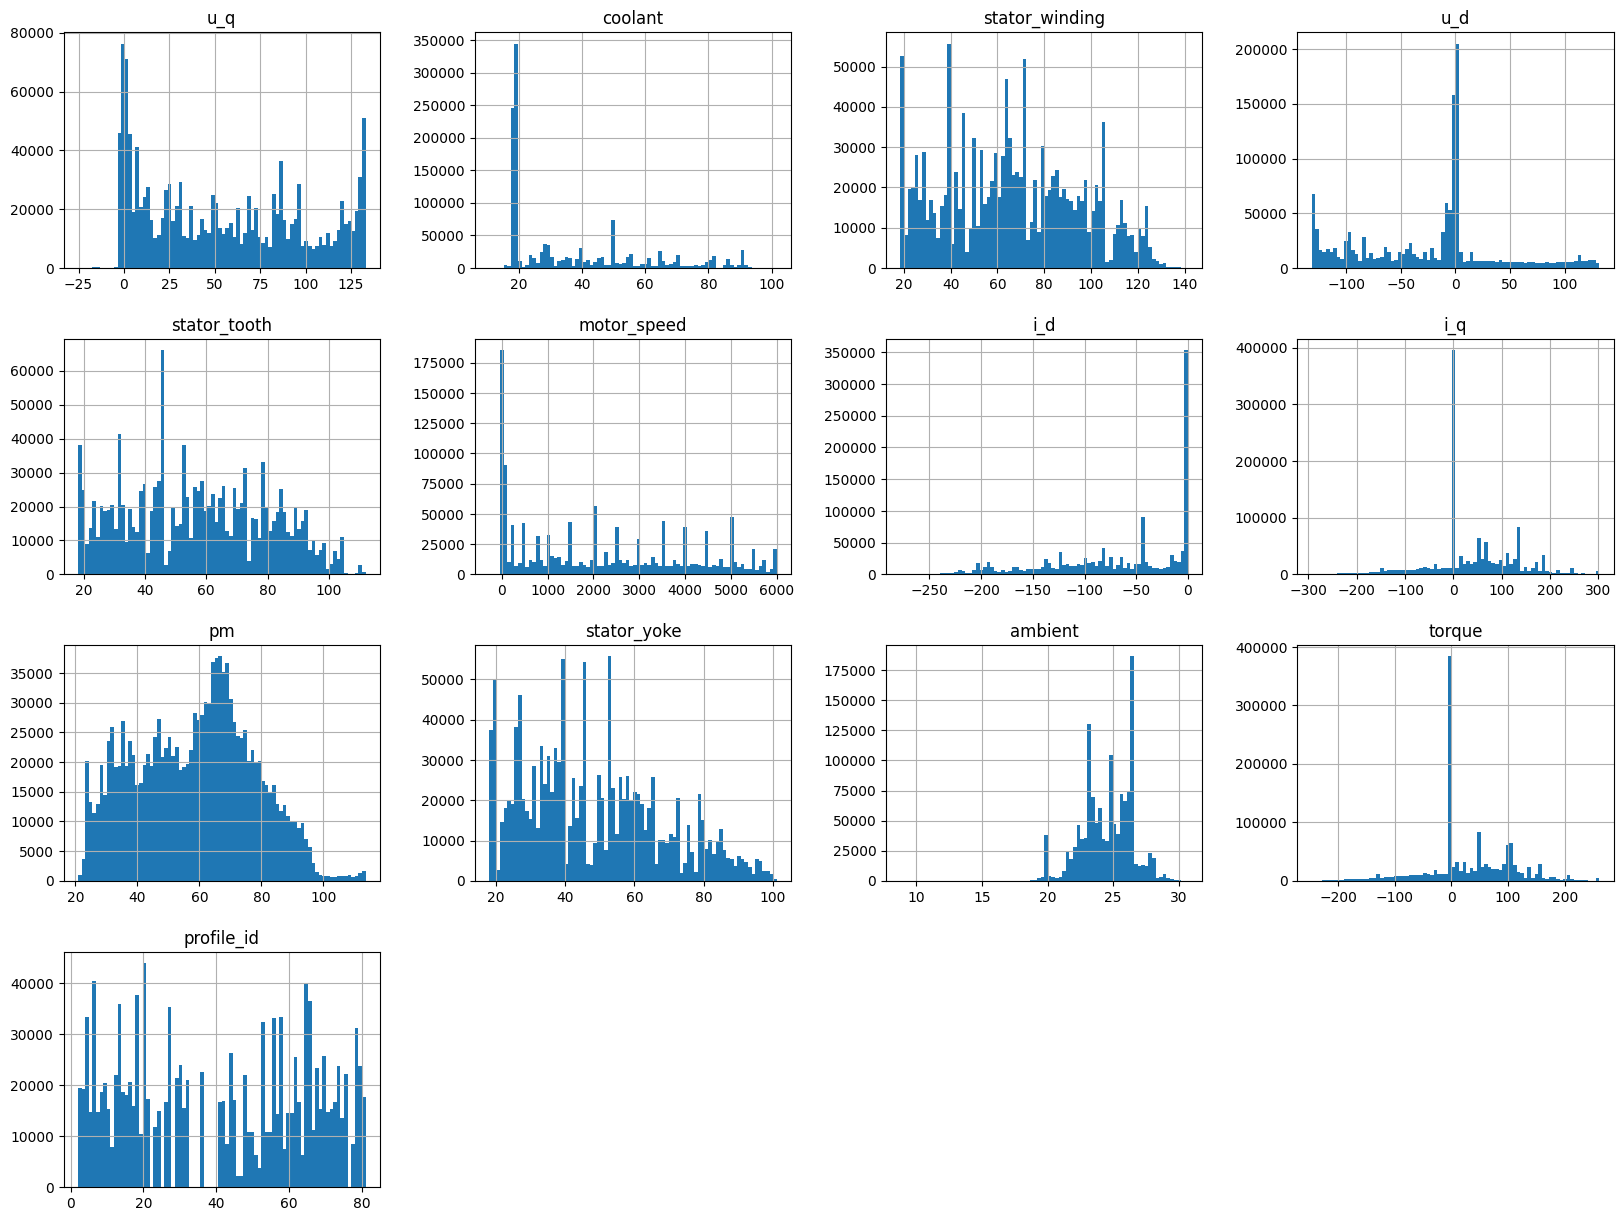

In [35]:
# Plots histograms for all features.
# Useful for detecting outliers, distribution shapes, and scale differences.
data.hist(bins=80, figsize=(20,15)) 
plt.show()

# komische striche, ggf. null ausschließen - motor aus???

**Zentrale Erkenntnisse:**


- **Größenordnung der Einheiten passt:**  
  Alle Messwerte befinden sich in sinnvollen physikalischen Größenordnungen.

- **Histogramme zeigen für die meisten Features eine annähernd Normalverteilung.**

- **Skalierung der Features variiert stark:**
  - `motor_speed`: Ø ≈ 2200, max ≈ 6000
  - `coolant`, `ambient`, `pm`: typischer Temperaturbereich 10–110 °C
  - `i_q`: zwischen -293 und +301 → hohe Dynamik in der Stromregelung
  - `u_d`: reicht von -131 bis +131 → symmetrische Verteilung
  → **Feature Scaling** ist notwendig für viele ML-Modelle.

- **Negative Werte bei `torque`, `i_q`, `i_d`, `u_d`, `u_q`.**

- **`profile_id`:**
  - Wertebereich: 2 bis 81
  - → nicht alle IDs sind vergeben.

- **Zielvariable `pm` (Permanentmagnet-Temperatur):**
  - Mittelwert: 58,5 °C
  - Minimum: 20,9 °C
  - Maximum: 113,6 °C
  → kein extremer Ausreißerbereich.

#### Trainings- und Testset erstellen

Um sicherzustellen, dass alle Messsessions (`profile_id`) im Trainings- und Testdatensatz proportional vertreten sind, wird ein **stratifiziertes Sampling** durchgeführt. Dadurch bleibt die Verteilung der Messsessions in beiden Datensätzen erhalten, was Über- oder Unterrepräsentation einzelner Sessions vermeiden und die Generalisierbarkeit des Modells verbessern soll.

Da der Datensatz sehr groß ist (~1,3 Mio. Einträge), reicht ein Testset mit **1% der Daten** aus, um valide Modellevaluationen durchzuführen (vgl. Vorlesung).

count    1.330816e+06
mean     4.079306e+01
std      2.504549e+01
min      2.000000e+00
25%      1.700000e+01
50%      4.300000e+01
75%      6.500000e+01
max      8.100000e+01
Name: profile_id, dtype: float64


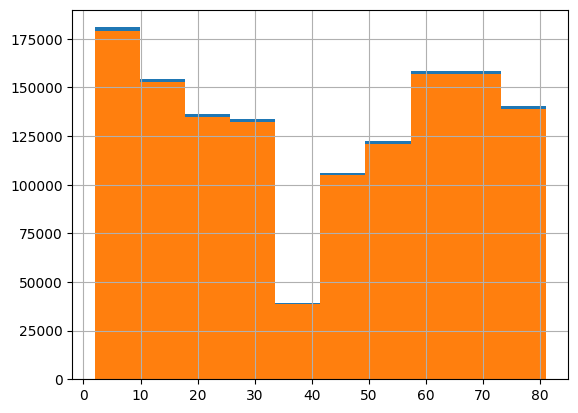

In [36]:
# sample a stratified test set from all sessions (multiple measurements can be distinguished from each other by column profile_id)
print(data["profile_id"].describe())


# Testsetsize = 1%, due to more then 100000 Datapoints
split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
for train_index, test_index in split.split(data, data["profile_id"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]


# Verify that the stratified test set (orange) preserves the same distribution shape as the full dataset (blue), 
# but with ~99% of the sample size (lower bars with identical relative frequencies).   
data["profile_id"].hist()    
strat_train_set["profile_id"].hist()
plt.show()

---
### 3. Explore the Data

#### Erstellung eines kompakten Explorations-Datensatzes

Für die explorative Datenanalyse wird ein kleiner, aber repräsentativer Ausschnitt aus dem Trainingsdatensatz benötigt. Ziel ist es, einfache Analysen, Visualisierungen und Vorverarbeitungsschritte schnell und ressourcenschonend durchzuführen – ohne direkt auf den vollständigen Trainings-Datensatz zugreifen zu müssen.

Dazu werde mittels **stratifiziertem Sampling** 20% des Trainingsdatensatzes ausgewählt, wobei die Verteilung der unterschiedlichen Messsessions (`profile_id`) beibehalten wird.

In [37]:
# copy the training set for exploration
data_exploration = strat_train_set.copy()

# sample the exploration_set down to 20% of the original trainingset for easy and fast exploration
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for _, exploration_index in split.split(data_exploration, data_exploration["profile_id"]):
    exploration_set = data_exploration.iloc[exploration_index].copy()
    

exploration_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263502 entries, 1636 to 323786
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   u_q             263502 non-null  float64
 1   coolant         263502 non-null  float64
 2   stator_winding  263502 non-null  float64
 3   u_d             263502 non-null  float64
 4   stator_tooth    263502 non-null  float64
 5   motor_speed     263502 non-null  float64
 6   i_d             263502 non-null  float64
 7   i_q             263502 non-null  float64
 8   pm              263502 non-null  float64
 9   stator_yoke     263502 non-null  float64
 10  ambient         263502 non-null  float64
 11  torque          263502 non-null  float64
 12  profile_id      263502 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 28.1 MB


# Study each attribute and its characteristics??!
    - name
    - type
    - % of missing values
    - noisiness
    - usefulness for task
    - type of distribution
    - ...

5. Visualize the data.

#### Verteilung der Zielvgröße `pm` - Permanetmagnet-Temeperatur

Die Verteilung der Zielgröße `pm` wird als Histogramm mit Dichtekurve dargestellt.  
Dies hilft, mögliche Schieflagen, Ausreißer oder Auffälligkeiten zu erkennen.

<Axes: xlabel='pm', ylabel='Count'>

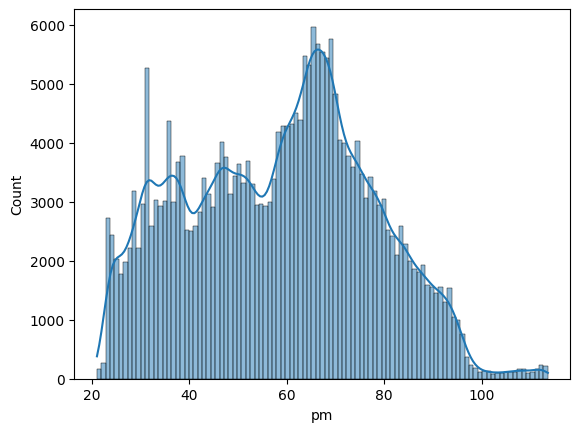

In [38]:
# Create a histogram of the 'pm' column from the 'exploration_set' DataFrame.
# Shows the distributions, skewness for target variable (pm).
# The KDE provides a smoothed representation of the data's distribution.
sns.histplot(exploration_set['pm'], kde=True)

# TODo: man sieht??

#### Korrelationsanalyse

Mit der Korrelationsmatrix wird untersucht, wie stark die einzelnen Features mit der Zielgröße `pm` (Permanentmagnet-Temperatur) zusammenhängen.  
Das Sortieren der Korrelationen nach `pm` zeigt, welche Messgrößen den größten Einfluss auf die Temperatur haben und damit für das Modell besonders relevant sein könnten. Dies wird unten zusätzlich grafisch als Heatmap dargestellt.

In [39]:
# calcutale correlation matrix
corr_matrix = exploration_set.corr()

# look at how much each attribute correlates with the pm temp:
corr_matrix["pm"].sort_values(ascending=False)

pm                1.000000
stator_tooth      0.832329
stator_winding    0.796250
stator_yoke       0.757200
ambient           0.514605
coolant           0.467733
motor_speed       0.459339
profile_id        0.386073
u_q               0.121543
torque           -0.118263
i_q              -0.143676
u_d              -0.170843
i_d              -0.429555
Name: pm, dtype: float64

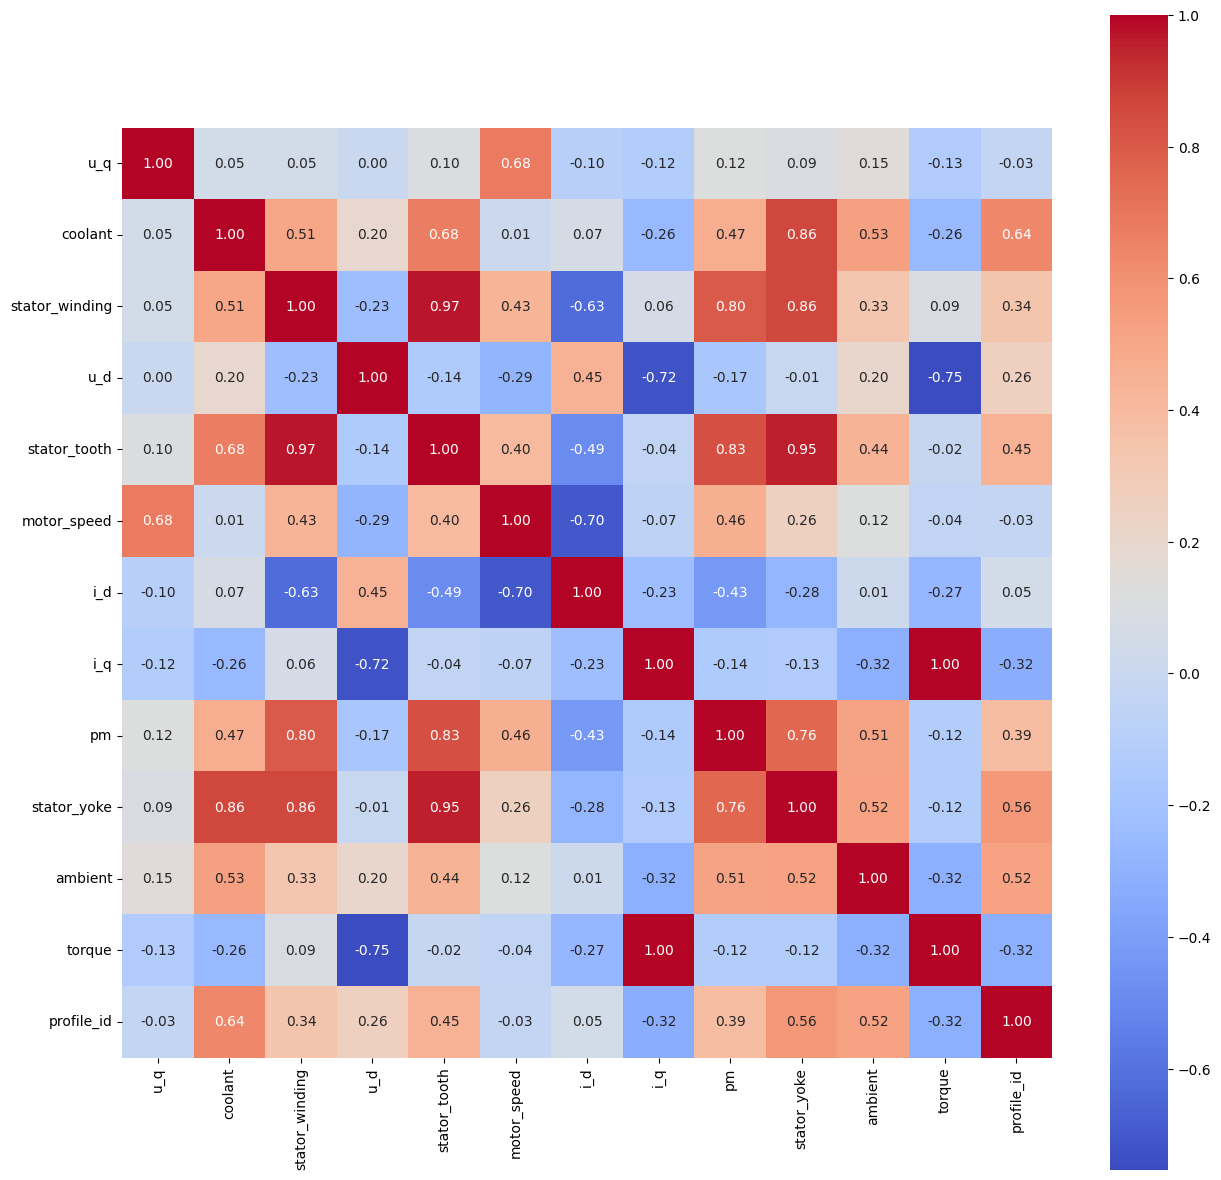

In [40]:
# Plot correlation matrix as a heatmap
# Annotate cells with correlation values, formatted to two decimals
# Use 'coolwarm' color map to highlight positive and negative correlations
# Set figure size and enforce square cells for better readability
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()

Die Analyse zeigt, dass die Temperaturen an verschiedenen Motorteilen sehr stark mit der Permanentmagnet-Temperatur (`pm`) korrelieren:  
- Besonders hohe positive Korrelationen haben `stator_tooth` (0,83), `stator_winding` (0,80) und `stator_yoke` (0,76).  
- Die Umgebungs- (`ambient`, 0,51) und Kühlwassertemperatur (`coolant`, 0,47) zeigen moderate positive Zusammenhänge.  
- die Motordrehzahl `motor_speed` korrelieren (0,46) ebenfalls positiv, wenn auch schwächer.  

Spannungen und Ströme weisen geringe bis mäßige negative Korrelationen auf, z. B. `i_d` (-0,43), was auf komplexere Einflüsse oder Gegenläufigkeiten hindeutet.

Die Korrelation von 0,39 zwischen `pm` und `profile_id` zeigt zwar einen gewissen Zusammenhang, aber `profile_id` ist eigentlich nur ein Identifikator für verschiedene Messsessions. Dieser Wert (0,39) spiegelt also keine physikalische Beziehung wider, sondern eher, dass unterschiedliche Messungen (Sessions) unterschiedliche Temperaturniveaus haben können. Für die Modellierung ist `profile_id` daher eher kein sinnvoller Prädiktor.

Die Motordrehzahl (`motor_speed`) ist eine zentrale Betriebsgröße, die mechanische Belastung und thermische Zustände beeinflusst (siehe Korrelation zu `pm`).  
Die Analyse der Korrelationen mit `motor_speed` identifiziert relevante Einflussgrößen und unterstützt die Auswahl signifikanter Features für die Modellierung.  

In [41]:
# look at how much each attribute correlates with the motor_speed:
corr_matrix["motor_speed"].sort_values(ascending=False)

motor_speed       1.000000
u_q               0.682638
pm                0.459339
stator_winding    0.432177
stator_tooth      0.398794
stator_yoke       0.256433
ambient           0.119980
coolant           0.012453
profile_id       -0.028454
torque           -0.043939
i_q              -0.068786
u_d              -0.287561
i_d              -0.701217
Name: motor_speed, dtype: float64

Die Motordrehzahl (`motor_speed`) zeigt starke positive Korrelationen mit den elektrischen Größen `u_q` (0,68) und eine starke negative Korrelation mit `i_d` (-0,70).  

Auch die Permanentmagnet-Temperatur (`pm`) sowie Temperaturen an Wicklung (`stator_winding`) und Zahn (`stator_tooth`) korrelieren (wie erwartet) moderat positiv mit der Drehzahl.  

Das Drehmoment (`torque`) korreliert kaum mit `pm` (-0,04).


#### Neue Attribut-Kombinationen

Abgeleitet aus den obigen Erkenntnissen und zur Erweiterung der Merkmalsbasis wird zunächst die elektrische Leistung (`power`) als neue Variable berechnet:

In [42]:
# Calculate the power and store it in a new 'power' column and calculate the correlation matrix with all other attributes
exploration_set["power"] = exploration_set["u_d"] * exploration_set["i_d"] + exploration_set["u_q"] * exploration_set["i_q"]
corr_matrix = exploration_set.corr()
corr_matrix["power"].sort_values(ascending=False)

power             1.000000
torque            0.755165
i_q               0.717492
motor_speed       0.280462
stator_winding    0.265565
pm                0.183579
stator_tooth      0.163777
stator_yoke       0.020200
u_q              -0.048766
coolant          -0.198643
ambient          -0.209536
profile_id       -0.253222
i_d              -0.487094
u_d              -0.992356
Name: power, dtype: float64

Die starke positive Korrelation zu `torque` (0,75) und `i_q` (0,72) bestätigt physikalisch erwartete Zusammenhänge. Allerdings zeigt `power` nur eine schwache positive Korrelation mit der Zielgröße `pm` (0,18), was auf eine begrenzte Aussagekraft der Leistung als Prädiktor für die Magnettemperatur hinweist.
Aufgrund dieser geringen Relevanz wird die Leistung als Feature für das Modell nicht weiter verfolgt.

Im nächsten Schritt erfolgt eine Untersuchung der **Stromstärke (current magnitude)** als möglicher aussagekräftigerer Prädiktor:

In [43]:
# Calculate the current magnitude and store it in a new 'current_magnitude' column and calculate the correlation matrix with all other attributes
exploration_set["current_magnitude"] = np.sqrt(exploration_set["i_d"]**2 + exploration_set["i_q"]**2)
corr_matrix = exploration_set.corr()
corr_matrix["current_magnitude"].sort_values(ascending=False)

current_magnitude    1.000000
stator_winding       0.573639
stator_tooth         0.420845
torque               0.397854
power                0.395944
motor_speed          0.383412
i_q                  0.373940
pm                   0.254592
stator_yoke          0.235736
u_q                 -0.014798
ambient             -0.052355
profile_id          -0.081115
coolant             -0.089711
u_d                 -0.354021
i_d                 -0.845792
Name: current_magnitude, dtype: float64

Die Korrelationsanalyse zeigt positive Zusammenhänge mit `torque` und `motor_speed`. Die Korrelation mit der Zielvariable `pm` ist mit 0,25 aber nicht sehr hoch.

Allerdings korreliert `current_magnitude` moderat positive mit den Temperaturen von Wicklung (`stator_winding`, 0,57) und Zahn (`stator_tooth`, 0,42), welche wiederum stark mit der Zielvariable korrelieren.

Diese Ergebnisse deuten darauf hin, dass die Stromstärke ein relevanter Einflussfaktor für die Temperaturentwicklung im Motor sein könnte und somit als Feature in die Modellierung aufgenommen werden sollte.

---
### 4. Prepare the Data

Im nächsten Schritt wird eine  Kopie des Trainingsdatensatzes (`strat_train_set`) erzeugt, damit das Originaldataset unverändert bleit.
Darauf aufbauend werden die Features vom Zielwert getrennt. Die Zielvariable `pm` wird als eigene Serie (`motor_pm_labels`) extrahiert, während die Trainingsdaten ohne `pm` als Eingabedaten (`motor`) verbleiben.  

# TODO
3. Select important features (drop attributes that provide no useful information for the task).
4. Use feature engineering.
    - decompose categorical features
    - add promising transformations for features
    - aggregate features into promissing new features
5. Use feature scaling (standardize or normalize features).

In [44]:
# Prepare the target labels by copying the 'pm' column
motor_pm_labels = strat_train_set["pm"].copy()

# Prepare the feature set by dropping the target column 'pm' for training
motor = strat_train_set.drop("pm", axis=1)

In [45]:
# drop attributes that provide no useful information for the task
motor = motor.drop("profile_id", axis=1)
#motor = motor.drop("coolant", axis=1) 
#motor = motor.drop("stator_winding", axis=1)
#motor = motor.drop("stator_tooth", axis=1)
#motor = motor.drop("stator_yoke", axis=1)
#motor = motor.drop("ambient", axis=1)

# Display information about the traingin DataFrame, to briefly validate a succseful preparation
motor.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque
486400,73.499413,18.620235,23.520418,-0.246484,23.678951,1499.983521,-2.000962,1.097150,21.984486,23.888302,-2.366589e-02
724527,70.820196,28.859377,79.982515,-3.026034,65.189878,1495.647860,-2.659218,4.360475,50.937160,26.384446,2.173315e+00
641872,-0.174199,79.659683,70.842393,3.290139,70.861331,0.002076,-2.000971,1.097257,72.114404,26.602693,-1.603729e-211
108384,4.176036,18.453747,19.713879,1.483652,19.082251,99.974022,-1.999888,1.095639,18.994600,21.466301,2.330701e-01
882919,107.053965,86.091312,96.735314,-76.085422,91.334451,3499.971770,-74.765850,61.168734,86.857632,25.000909,5.000000e+01


* Im Datensatz sind keine fehlenden Werte vorhanden, daher ist keine Datenimputation notwendig.  
* Da alle Features numerisch sind, ist kein Encoding kategorialer Variablen erforderlich.

#### Transformer

Es soll das neue Feature `current_magnitude` ergänzt werden:
Dazu wird ein Transformer der Klasse `CurrentMagnitudeAdder` implementiert, der als Teil der Datenvorverarbeitung die Stromstärke berechnet und als neue Spalte an den Datensatz anhängt.  
Der Transformer enthält den Hyperparameter add_current_magnitude, mit dem gesteuert werden kann, ob das neue Feature current_magnitude hinzugefügt wird oder nicht.

In [46]:
# Custom transformer to add a new feature 'current_magnitude' to the dataset
# Inherits from BaseEstimator and TransformerMixin to integrate with scikit-learn pipelines

class CurrentMagnitudeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_current_magnitude=True):
        self.add_current_magnitude = add_current_magnitude

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # If feature addition is disabled, return original data unchanged
        if not self.add_current_magnitude:
            return X

        # Calculate current magnitude as sqrt(i_d^2 + i_q^2) and add as new column
        current_magnitude = np.sqrt(X["i_d"]**2 + X["i_q"]**2)
        return X.assign(current_magnitude=current_magnitude)



# Instantiate transformer with feature addition enabled
attr_adder = CurrentMagnitudeAdder(add_current_magnitude=True)

# Apply the transformer to the feature set 'motor'
motor_extra_attribs = attr_adder.transform(motor)

# Display first rows to verify the new feature
motor_extra_attribs.head()


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque,current_magnitude
486400,73.499413,18.620235,23.520418,-0.246484,23.678951,1499.983521,-2.000962,1.097150,21.984486,23.888302,-2.366589e-02,2.282013
724527,70.820196,28.859377,79.982515,-3.026034,65.189878,1495.647860,-2.659218,4.360475,50.937160,26.384446,2.173315e+00,5.107365
641872,-0.174199,79.659683,70.842393,3.290139,70.861331,0.002076,-2.000971,1.097257,72.114404,26.602693,-1.603729e-211,2.282073
108384,4.176036,18.453747,19.713879,1.483652,19.082251,99.974022,-1.999888,1.095639,18.994600,21.466301,2.330701e-01,2.280346
882919,107.053965,86.091312,96.735314,-76.085422,91.334451,3499.971770,-74.765850,61.168734,86.857632,25.000909,5.000000e+01,96.599929


#### Transformations Pipeline

Da alle Features numerisch sind und sequenzeill abgearbeitet werden, genügt eine einfache Pipeline. Ein ColumnTransformer wäre nur nötig, wenn unterschiedliche Spalten unterschiedliche Vorverarbeitungen brauchen.

# Scaler art????
+ Begründung

In [47]:
pipeline = Pipeline([
        ('attribs_adder', CurrentMagnitudeAdder()), # Add custom feature 'current_magnitude'
        ('minmax_scaler', MinMaxScaler()), # Transformed feature matrix ready for modeling
    ])


# Fit pipeline on training data and apply transformations
motor_prepared = pipeline.fit_transform(motor)

# Display transformed feature matrix for verification
motor_prepared

array([[0.62396032, 0.08789783, 0.04019157, ..., 0.68875163, 0.4856284 ,
        0.00631225],
       [0.60703838, 0.20044708, 0.50006651, ..., 0.80257113, 0.48995767,
        0.01412755],
       [0.15863741, 0.75884708, 0.42562164, ..., 0.81252277, 0.48567504,
        0.00631241],
       ...,
       [0.70788929, 0.59810624, 0.70212916, ..., 0.79471442, 0.57926196,
        0.39653993],
       [0.32832825, 0.22058807, 0.55632123, ..., 0.80256344, 0.26803635,
        0.60589899],
       [0.16286624, 0.39499134, 0.24177286, ..., 0.80257297, 0.48567504,
        0.00631241]], shape=(1317507, 12))

---
### 5. Select and Train your Models

#### Untersuchte Modele

Neben dem `Random Forest` (nichtlinear, robust, bildlich vorstellbar) und einem neuronalen Netz `ANN` (leistungsstark, aber komplex) wird als drittes Modell eine lineare Regression gewählt.

Begründung:
Die lineare Regression dient als Baseline-Modell: Sie ist einfach, schnell trainiert und gut interpretierbar. So lässt sich nachvollziehen, ob komplexere Modelle wie ANN oder Random Forest tatsächlich einen Mehrwert bieten oder ob bereits eine lineare Beziehung ausreicht.

#### Lineare Regression

# Todo


1. Learn the basics about the models you've been assigned.
2. Select a 3rd model on your own. Use criteria for your selection.
3. Make a plan for training and evaluation of the models.
4. Build your models (select meaningful values for the model parameters).
5. Train your models with the training set.
6. Measure and compare the performance of your models (use N-fold cross-validation).
7. Analyze the most significant parameters for each model.
8. Analyze the types of errors the models make.

In [48]:
from sklearn.linear_model import LinearRegression

# Instantiate a linear regression model
lin_reg = LinearRegression()

# Train the model on the preprocessed training data and target labels
lin_reg.fit(motor_prepared, motor_pm_labels)

LinearRegression()

Zur Kontrolle wird die vollständige Preprocessing-Pipeline auf einige wenige Trainingsdaten angewendet. Um ein erstes Gefühl für die Modellgüte zu bekommen, werden die vorhergesagten Werte (`Predictions`) werden den tatsächlichen Werten (`Actual Labels`) gegenübergestellt.

In [49]:
# try the full preprocessing pipeline on a few training instances
some_data = motor.iloc[:5]
some_labels = motor_pm_labels.iloc[:5]

# Apply the preprocessing pipeline
some_data_prepared = pipeline.transform(some_data)

# Make predictions and compare them to the actual labels
print("Predictions   :", np.round(lin_reg.predict(some_data_prepared),1))
print("Actual Labels :", list(some_labels))

Predictions   : [36.6 68.3 67.9 29.8 74.8]
Actual Labels : [31.186717987060547, 60.64904849267637, 63.75366416399909, 23.9774112701416, 76.98651792173555]


Die Ergebnisse sehen auf den ersten Blick schon ganz gut aus. Im nächsten Schritt wird das trainierte lineare Regressionsmodell auf dem gesamten vorverarbeiteten Trainingsdatensatz angewendet, um Vorhersagen zu generieren.

#### Modellbewertung mittels n-fold cross-validation

Die Funktion `evaluate_model_crossFold` soll die objektive Evaluierung aller untersuchten Regressionsmodellen durch **n-fold cross-validation** ermöglichen. 

Dabei wird das Modell mehrfach auf unterschiedlichen Trainings- und Validierungssplits getestet, um Überanpassung zu vermeiden und die Verallgemeinerungsfähigkeit zuverlässig abzuschätzen.

Die verwendete Bewertungsmetrik ist der **Root Mean Squared Error (RMSE)**, der die durchschnittliche Vorhersageabweichung quantifiziert und insbesondere größere Fehler stärker gewichtet.

Die Funktion liefert neben den einzelnen RMSE-Werten der Folds auch deren Mittelwert und Standardabweichung zurück, um die Performance stabil und vergleichbar über verschiedene Modelle zu bewerten.


In [50]:
from sklearn.model_selection import cross_val_score

def evaluate_model_crossFold(model, training_features, training_labels, cv=10, display=False):
    """
    Evaluates a regression model using cross-validation (RMSE).

    Parameters:
    - model: the regression model to evaluate
    - training_features: preprocessed training features
    - training_labels: training labels
    - cv: number of cross-validation folds (default: 10)
    - display: if True, prints scores and statistics
    
    Returns:
    - Dictionary with RMSE scores, mean, and standard deviation  
    """
    scores = cross_val_score(model, training_features, training_labels,
                             scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)

    results = {
        "rmse_scores": rmse_scores,
        "mean_rmse": rmse_scores.mean(),
        "std_rmse": rmse_scores.std()
    }

    if display:
        print("RMSE scores:", results["rmse_scores"])
        print("Mean RMSE  :", results["mean_rmse"])
        print("Std RMSE   :", results["std_rmse"])

    return results

Zunächst die Evaluation des Liniaren-Regressions-Modells:

In [51]:
# cross-validate Model
lin_reg_results = evaluate_model_crossFold(lin_reg, motor_prepared, motor_pm_labels, cv=5, display=True)

RMSE scores: [7.21817819 7.22388557 7.2355867  7.26354276 7.2421006 ]
Mean RMSE  : 7.236658762769056
Std RMSE   : 0.01586315210800782


# todo


In [52]:
import joblib

# Bundle everything in one object
lin_reg_model_package = {
    "model": lin_reg,
    "hyperparams": lin_reg.get_params(),
    "cv_results": lin_reg_results
}

# save Model
joblib.dump(lin_reg_model_package, "models/lin_reg.pkl")

['models/lin_reg.pkl']

In [53]:
# Utility function to load a saved model package containing the trained model,
# its hyperparameters, cross-validation scores and predictions.
def load_model_package(model_path):
    """
    Loads a previously saved model package (.pkl file), which contains:
    - the trained model,
    - hyperparameters,
    - cross-validation results,
    - predictions on training data.

    Parameters:
    - model_path: Path to the saved .pkl file

    Returns:
    - A dictionary with keys:
        - "model": the trained model (e.g., RandomForestRegressor)
        - "hyperparams": hyperparameters used during training
        - "cv_results": cross-validation scores

    Example usage:
    ----------------
    package = load_model_package("models/forest_reg.pkl")
    model = package["model"]
    params = package["hyperparams"]
    scores = package["cv_results"]
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model package not found at: {model_path}")

    loaded_package = joblib.load(model_path)
    return loaded_package

package = load_model_package("models/forest_reg.pkl")

# todo
#### Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a Random Forest Regressor with 3 trees and a fixed random state for reproducibility
forest_reg = RandomForestRegressor(n_estimators=3, random_state=42)

# Train the model on the preprocessed training data and target labels
forest_reg.fit(motor_prepared, motor_pm_labels)

RandomForestRegressor(n_estimators=3, random_state=42)

In [55]:
# cross-validate Model
forest_reg_results = evaluate_model_crossFold(forest_reg, motor_prepared, motor_pm_labels, cv=3, display=True)


# Bundle everything in one object
forest_reg_model_package = {
    "model": forest_reg,
    "hyperparams": forest_reg.get_params(),
    "cv_results": forest_reg_results
}

# save Model
joblib.dump(forest_reg_model_package, "models/forest_reg.pkl")

RMSE scores: [0.78727876 0.82309339 0.81932902]
Mean RMSE  : 0.8099003899866233
Std RMSE   : 0.016069564668066368


['models/forest_reg.pkl']

# todo

unterschiede crossEval erklären

7. Analyze the most significant parameters for each model

→ Was ist gemeint?

Untersuche, welche Eingabefeatures (Spalten) den größten Einfluss auf die Vorhersage des jeweiligen Modells haben.

Beispiel:

    Bei einem Random Forest kannst du feature_importances_ verwenden.

    Bei einer linearen Regression sagen dir die Koeffizienten, wie stark ein Feature die Zielgröße beeinflusst.

    Bei einem ANN (neuronalen Netz) ist das schwieriger, aber mit Techniken wie Permutation Importance oder SHAP-Werten machbar.

Ziel: Verstehen, auf welche Signale dein Modell am meisten reagiert.
8. Analyze the types of errors the models make

→ Was ist gemeint?

Schaue dir an, wo und wann das Modell besonders schlecht vorhersagt, z. B.:

    Macht es bei hohen Temperaturen größere Fehler?

    Sind die Fehler bei bestimmten Profilen (profile_id) systematisch höher?

    Unterschätzt oder überschätzt es generell?

Typische Methoden:

    Scatterplot: Vorhersage vs. Ist-Wert (y_pred vs. y_true)

    Histogramm der Residuen (Fehler)

    Fehleranalyse nach Subgruppen: z. B. mittlere Abweichung pro profile_id

Ziel: Herausfinden, wo dein Modell Schwächen hat – z. B. bei Randwerten, Ausreißern oder bestimmten Bedingungen.

---
### 6. Fine-Tune your Models

1. Fine-tune the hyperparameters using cross-validation.
    - treat your data transformation choices as hyperparameters, especially when you are not sure about them. (e.g. if you are not sure whether to replace missing values with zeros or with the median value, or to just drop the rows.)
    - use grid search and random search $\to$ compare and evaluate the results.
2. Compare the results of all three models after the fine-tuning process to determine the best hyperparameters.
3. Select a final model and measure its performance on the test set to estimate the generalization error.
    - dont tweak your model after measuring the generalization error: you would just start overfitting the test set.
4. Document the results of the examined models. Pay particular attention to the final model.

---
### 7. Present Your Solution

1. Document what you have done.
    - write a summary of the results in a new, final section
    - explain why your solution achieves the task objective
